In [99]:
import sys
sys.path.append('../src/')
import pandas as pd
import csv
import networkx as nx
import numpy as np
import os 
from utils import *
import meshio
import imp 
from fenics import *
import matplotlib.pyplot as plt

# Network playground

In this notebook we want to play around with making and meshing networks by combining the features of ``FEniCS`` and ``networkx``. 

## Hello world network
First we make a simple network by just adding nodes to make a y-shaped network:

Bifurcation nodes:  [1]
Boundary nodes:  [0, 2, 3]


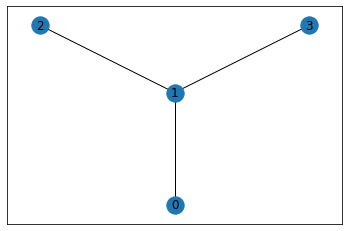

In [101]:
import fenics_graph as fg
imp.reload(fg)

G = fg.FenicsGraph()
G.add_nodes_from([0, 1, 2, 3])
G.nodes[0]['pos']=[0,0,0]
G.nodes[1]['pos']=[0,0.5,0]
G.nodes[2]['pos']=[-0.2,0.8,0]
G.nodes[3]['pos']=[0.2,0.8,0]

G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(1,3)

G.make_mesh()

File('mesh.pvd')<<Function(FunctionSpace(G.global_mesh, 'CG', 1))
File('tangent.pvd')<<G.global_tangent

# Flatten to 2D and plot
G_2D = G.copy() # deep copy
for v in G.nodes():
    G_2D.nodes[v]['pos'] = G.nodes[v]['pos'][0:2]
pos=nx.get_node_attributes(G_2D,'pos')
nx.draw_networkx(G_2D, pos)

print('Bifurcation nodes: ', G.bifurcation_ixs)
print('Boundary nodes: ', G.boundary_ixs)


## Networks from Secomb data 

In [102]:
name = 'rattm98'

ur_infile = '../data/' + name + '.txt'
ur_outfile = '../data/'  + name + '-csv.txt'

with open(ur_infile) as fin, open(ur_outfile, 'w') as fout:
    o=csv.writer(fout)
    for line in fin:
        o.writerow(line.split())

In [103]:
names=["Segment", "Node1", "Node2", "diam.", "length", 
       "node from x", "node from y", "node from z",
       "node to x", "node to y", "node to z"]
data=pd.read_csv(ur_outfile, header=None, names=names, skiprows=2)


data.iloc[:,1] -= 1
data.iloc[:,2] -= 1

data

,Segment,Node1,Node2,diam.,length,node from x,node from y,node from z,node to x,node to y,node to z
1,A1,0,1,15.5,344.27,170.0,0.0,213.0,95.0,336.0,213.0
2,A2,1,2,13.5,109.66,95.0,336.0,213.0,107.0,445.0,213.0
3,A3,2,3,16.5,90.14,107.0,445.0,213.0,57.0,520.0,213.0
4,A4,2,4,13.8,84.08,107.0,445.0,213.0,145.0,520.0,213.0
5,B1,5,6,12.3,39.12,137.0,330.0,153.0,134.0,369.0,153.0
...,...,...,...,...,...,...,...,...,...,...,...
100,V4,87,88,6.4,23.69,386.0,272.0,93.0,363.0,268.0,97.0
101,V5,88,89,5.3,31.76,363.0,268.0,97.0,372.0,296.0,109.0
102,V6,89,90,6.0,31.45,372.0,296.0,109.0,400.0,283.0,115.0
103,V7,90,91,6.3,36.73,400.0,283.0,115.0,423.0,255.0,121.0


Bifurcation nodes:  [1, 2, 5, 9, 10, 16, 24, 28, 31, 32, 33, 36, 40, 41, 49, 50, 52, 58, 70, 71, 74, 82, 85]
Boundary nodes:  [0, 3, 4, 8, 11, 12, 15, 45, 56, 61, 62, 64, 65, 80, 83, 84, 86]


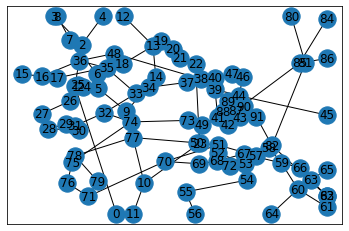

In [104]:
imp.reload(fg)

G = fg.FenicsGraph()

nodes1, nodes2 = data.iloc[:,1], data.iloc[:,2]
node_ixs = np.unique([nodes1, nodes2])
G.add_nodes_from(node_ixs)

for i in range(0, data.shape[0]):
    v1, v2 = data.iloc[i, 1:3]
    G.add_edge(v1, v2)

# Add the positions of each node
# We iterate over all the edges and add the position of the connected vertices
for i in range(0, data.shape[0]):
    v1 = int(data.iloc[i][1])  
    v2 = int(data.iloc[i][2])

    G.nodes[v1]['pos'] = [data.iloc[i][5],data.iloc[i][6],data.iloc[i][7]]
    G.nodes[v2]['pos'] = [data.iloc[i][8],data.iloc[i][9],data.iloc[i][10]]

G.make_mesh()
pos=nx.get_node_attributes(G,'pos')

# Flatten to 2D and plot
G_2D = G.copy() # deep copy
for v in G.nodes():
    G_2D.nodes[v]['pos'] = G.nodes[v]['pos'][0:2]
pos=nx.get_node_attributes(G_2D,'pos')
nx.draw_networkx(G_2D, pos)

File('mesh.pvd')<<Function(FunctionSpace(G.global_mesh, 'CG', 1))

print('Bifurcation nodes: ', G.bifurcation_ixs)
print('Boundary nodes: ', G.boundary_ixs)

## Pial network data

Lastly we look at network data from pial arteries. We take data from the paper:
Topological basis for the robust distribution of blood to rodent neocortex, Blinder et. al.
https://www.pnas.org/doi/10.1073/pnas.1007239107

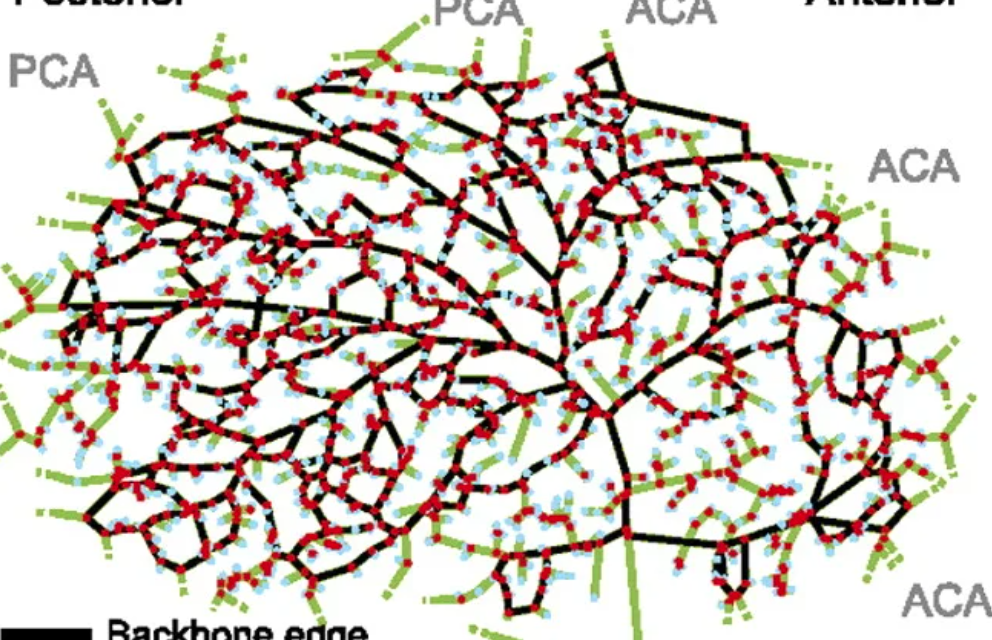

In [105]:
from IPython.display import Image
Image(filename = "../data/pial.png", width=500, height=400)

Some clicking in webplotdigitizer and manual wrangling yields this:

fenics_graph.FenicsGraph

Bifurcation nodes:  [1, 2, 3, 4, 8, 9, 10, 11, 12, 17, 23, 25, 29, 30, 35, 38, 45, 48, 51, 54, 55, 56, 58, 60, 62, 66, 67, 68, 70, 77, 79, 80, 83, 84, 88, 91, 94, 96, 99, 103, 110, 113, 118, 121, 129, 133, 166]
Boundary nodes:  [0, 46, 47, 50, 61, 157, 165]


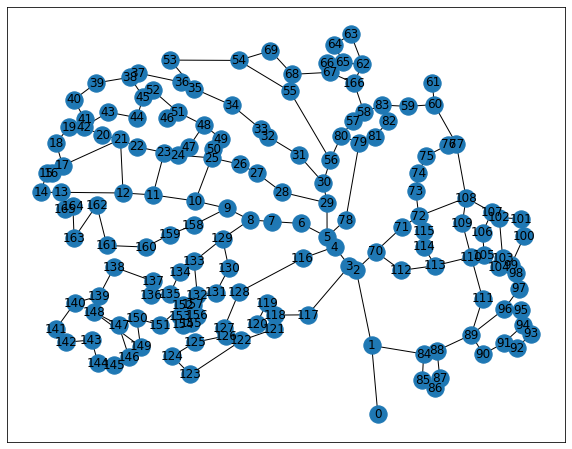

In [106]:
plt.figure(figsize=(10,8))

G = naive_pial_network('../data/pial.csv')
G.make_mesh()

pos=nx.get_node_attributes(G,'pos')
nx.draw_networkx(G, pos)

print('Bifurcation nodes: ', G.bifurcation_ixs)
print('Boundary nodes: ', G.boundary_ixs)

TODO: Check if we can do the extraction automatically using
    https://github.com/Image-Py/sknw

In [92]:
def naive_pial_network(fname):
    '''
    Make graph from picture of a pial network
    The points were extracted using webplotdigitizer and 
    the connections are hard coded
    '''
    
    G = fg.FenicsGraph()
    
    with open('../data/pial.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        for ix, row in enumerate(csv_reader):
            G.add_node(ix, pos=[float(row[0]), float(row[1])])

    G.add_edge(2,70); G.add_edge(3,117); G.add_edge(1,84)

    G.add_edges_from( [[i,i+1] for i in range(0,19)] )
    G.add_edges_from( [[i,i+1] for i in range(20,45)] )
    G.add_edges_from( [[i,i+1] for i in range(53,56)] )
    G.add_edges_from( [[i,i+1] for i in range(70,77)] )
    G.add_edges_from( [[i,i+1] for i in range(62,68)] )
    G.add_edges_from( [[i,i+1] for i in range(158,165)] )
    G.add_edges_from( [[i,i+1] for i in range(129,150)] )
    G.add_edges_from( [[i,i+1] for i in range(117,128)] )
    G.add_edges_from( [[i,i+1] for i in range(84,111)] )
    G.add_edges_from( [[i,i+1] for i in range(112,115)] )
    G.add_edges_from( [[i,i+1] for i in range(59,61)] )
    G.add_edges_from( [[i,i+1] for i in range(47,50)] )
    G.add_edges_from( [[i,i+1] for i in range(51,52)] )
    G.add_edges_from( [[i,i+1] for i in range(81,83)] )

    G.add_edges_from( [[i,i+1] for i in range(150,157)] )

    G.add_edge(56,80); G.add_edge(80,79); G.add_edge(79,81);
    G.add_edge(57,80); G.add_edge(57,58); G.add_edge(58,83);
    G.add_edge(83,59); G.add_edge(30,56); G.add_edge(9,158);

    G.add_edge(84,88); G.add_edge(89,96); G.add_edge(89,111);
    G.add_edge(54,69); G.add_edge(68,69); G.add_edge(68,55);
    G.add_edge(66,62); G.add_edge(53,35);
    G.add_edge(58,166); G.add_edge(166,67);  G.add_edge(166,62);

    G.add_edge(25,10); G.add_edge(23,11); G.add_edge(21,12);
    G.add_edge(91,94); G.add_edge(72,108);G.add_edge(70,112);
    G.add_edge(103,99); G.add_edge(77,108); G.add_edge(77,60);

    G.add_edge(5,78); G.add_edge(78,79); G.add_edge(4,116);
    G.add_edge(19,42); G.add_edge(42,20); G.add_edge(17,21);
    G.add_edge(45,52); G.add_edge(46,51); G.add_edge(51,48);
    G.add_edge(45,38);

    G.add_edge(8,129); G.add_edge(129,133); G.add_edge(113,110);
    G.add_edge(72,115); G.add_edge(116, 128); G.add_edge(121, 118);
    G.add_edge(5,29);
    
    return G
